In [1]:
import networkx as nx
import geopandas as gp
import pandas as pd 
import numpy as np
from glob import glob
from shapely.geometry import Point
import matplotlib.pyplot as plt
import json
import folium

import sklearn
from sklearn.cluster import spectral_clustering

from scipy.cluster import hierarchy
from scipy.spatial import distance

%matplotlib inline

# Download and parse data for networkx

In [3]:
! curl -O https://s3.amazonaws.com/tripdata/201307-201402-citibike-tripdata.zip
! unzip 201307-201402-citibike-tripdata.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  170M  100  170M    0     0  3369k      0  0:00:51  0:00:51 --:--:-- 3458k0:00:52 3438k 0:00:51  0:00:47  0:00:04 3454k
Archive:  201307-201402-citibike-tripdata.zip
  inflating: 2014-02 - Citi Bike trip data.csv  
  inflating: 2014-01 - Citi Bike trip data.csv  
  inflating: 2013-12 - Citi Bike trip data.csv  
  inflating: 2013-11 - Citi Bike trip data.csv  
  inflating: 2013-10 - Citi Bike trip data.csv  
  inflating: 2013-09 - Citi Bike trip data.csv  
  inflating: 2013-08 - Citi Bike trip data.csv  
  inflating: 2013-07 - Citi Bike trip data.csv  


In [107]:
list(data.columns)

['tripduration',
 'starttime',
 'stoptime',
 'start station id',
 'start station name',
 'start station latitude',
 'start station longitude',
 'end station id',
 'end station name',
 'end station latitude',
 'end station longitude',
 'bikeid',
 'usertype',
 'birth year',
 'gender']

In [4]:
data= pd.concat([pd.read_csv(f) for f in glob("* trip data.csv")])

od =(data.groupby(['start station id', 'end station id'])
         .count()
         .rename(columns={'tripduration' : 'weight'})
         .assign(inv_weight= lambda x: 1.0/x['weight'] )
         .reset_index()[['start station id', 'end station id','weight','inv_weight']])

network = nx.from_pandas_dataframe(od,
                                   source= 'start station id',
                                   target='end station id',
                                   edge_attr='inv_weight',
                                   create_using=nx.DiGraph())
data.groupby('bikeid').count().sort_values(by='gender',ascending=False).head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,usertype,birth year,gender
bikeid,,,,,,,,,,,,,,
17279,1341,1341,1341,1341,1341,1341,1341,1341,1341,1341,1341,1341,1341,1341
16049,1331,1331,1331,1331,1331,1331,1331,1331,1331,1331,1331,1331,1331,1331
18165,1324,1324,1324,1324,1324,1324,1324,1324,1324,1324,1324,1324,1324,1324
16399,1313,1313,1313,1313,1313,1313,1313,1313,1313,1313,1313,1313,1313,1313
15013,1305,1305,1305,1305,1305,1305,1305,1305,1305,1305,1305,1305,1305,1305


# Isolate most active bike

In [27]:
busybike = data[data['bikeid']==17279]
busybike.sort_values(by='starttime').head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
223259,528,2013-07-11 08:16:05,2013-07-11 08:24:53,469,Broadway & W 53 St,40.763441,-73.982681,529,W 42 St & 8 Ave,40.757570,-73.990985,17279,Subscriber,1977,1
223602,983,2013-07-11 08:25:19,2013-07-11 08:41:42,529,W 42 St & 8 Ave,40.757570,-73.990985,440,E 45 St & 3 Ave,40.752554,-73.972826,17279,Subscriber,1976,1
234904,887,2013-07-11 17:17:42,2013-07-11 17:32:29,440,E 45 St & 3 Ave,40.752554,-73.972826,497,E 17 St & Broadway,40.737050,-73.990093,17279,Subscriber,1975,2
237818,622,2013-07-11 18:33:19,2013-07-11 18:43:41,466,W 25 St & 6 Ave,40.743954,-73.991449,528,2 Ave & E 31 St,40.742909,-73.977061,17279,Subscriber,1974,1
238245,1061,2013-07-11 18:48:19,2013-07-11 19:06:00,528,2 Ave & E 31 St,40.742909,-73.977061,281,Grand Army Plaza & Central Park S,40.764397,-73.973715,17279,Subscriber,1983,2


# Find jumps (or rebalancing routes) for most active bike

In [37]:
busybikenext = (busybike.sort_values(by='starttime')
            .assign(nextstationid = busybike.sort_values(by='starttime')['start station id'] \
                    .shift(-1).fillna(0).astype('int')))

jumps = busybikenext[~(busybikenext['end station id'] == busybikenext['nextstationid'])]

jump_count =(jumps.groupby(['end station id', 'nextstationid'])
         .count()
         .rename(columns={'tripduration' : 'weight'})
         .assign(inv_weight= lambda x: 1.0/x['weight'] )
         .reset_index()[['end station id',
                         'nextstationid',
                         'weight',
                         'inv_weight']])

jumpnetwork = nx.from_pandas_dataframe(jump_count.query('nextstationid != 0'),
                                       source= 'end station id',
                                       target='nextstationid',
                                       edge_attr='inv_weight',
                                       create_using=nx.DiGraph())

# Find all station node positions

In [38]:
stations = (data[['start station id', 'start station latitude', 'start station longitude','start station name',]]
            .drop_duplicates('start station id')
            .rename(columns={'start station latitude':'latitude', 'start station longitude':'longitude'})
            .set_index('start station id'))
station_positions={}
for c in stations.index:
    station_positions[c]=(stations['longitude'][c],stations['latitude'][c])

# Plotting busybike jump network with networkx

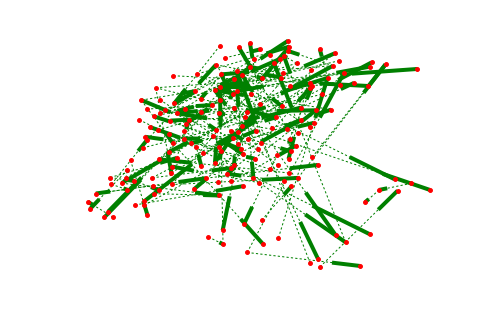

In [39]:
nx.draw(jumpnetwork,pos=station_positions,with_labels=False,node_size=15,
        style='dotted',edge_color='green',arrows=True)

# Plot rebalancing (jump) network for all bikes

In [ ]:
# This cell takes a while to run... warning!
all_jumps = pd.DataFrame()
for i in data['bikeid'].unique():
    bike = data[data['bikeid']==i] 
    nextbike = (bike.sort_values(by='starttime')
                        .assign(nextstationid = bike.sort_values(by='starttime')['start station id'].shift(-1).fillna(0).astype('int'))
                )
    jumps = nextbike[~(nextbike['end station id'] == nextbike['nextstationid'])]
    jumps.head()
    all_jumps = all_jumps.append(jumps)

In [129]:
all_jump_count =(all_jumps.query('nextstationid != 0').groupby(['end station id', 'nextstationid'])
         .count()
         .rename(columns={'tripduration' : 'weight'})
         .assign(inv_weight= lambda x: 1.0/x['weight'] )
         .reset_index()[['end station id',
                         'nextstationid',
                         'weight',
                         'inv_weight']])

In [133]:
# Find most frequent jump routes
all_jump_count.sort_values(by='weight',ascending=False).head()

,end station id,nextstationid,weight,inv_weight
58143,477,465,2811,0.000356
70985,529,2021,1445,0.000692
68925,521,490,1324,0.000755
69660,524,477,639,0.001565
62019,493,529,639,0.001565


In [40]:
# Use networkx to analyze total jump network and top-10 jump routes

alljumpnetwork = nx.from_pandas_dataframe(all_jump_count,
                                       source= 'end station id',
                                       target='nextstationid',
                                       edge_attr='inv_weight',
                                       create_using=nx.DiGraph())
topjumpnetwork = nx.from_pandas_dataframe(all_jump_count.sort_values(by='weight',ascending=False).head(10),
                                       source= 'end station id',
                                       target='nextstationid',
                                       edge_attr='inv_weight',
                                       create_using=nx.DiGraph())

NameError: name 'all_jump_count' is not defined

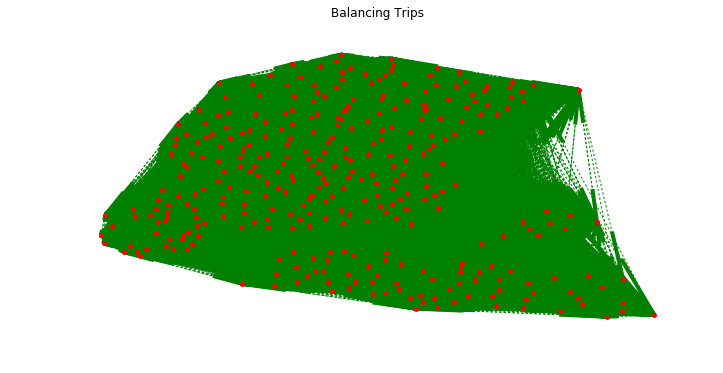

In [146]:
# We're plotting a lot of jump routes here -- may take a minute or two
plt.pyplot.figure(figsize = (12,6))
plt.pyplot.title('All Balancing Trips')
nx.draw(alljumpnetwork,pos=station_positions,with_labels=False,node_size=15,style='dotted',edge_color='green',arrows=True)

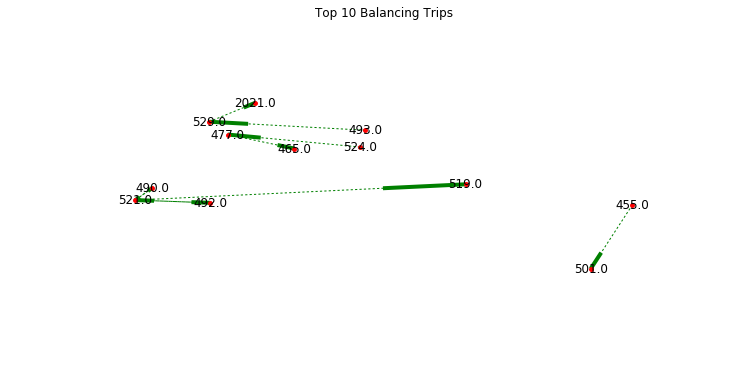

In [149]:
plt.pyplot.title('Top 10 Balancing Trips')
nx.draw(topjumpnetwork,pos=station_positions,with_labels=True,node_size=15,style='dotted',edge_color='green',arrows=True)

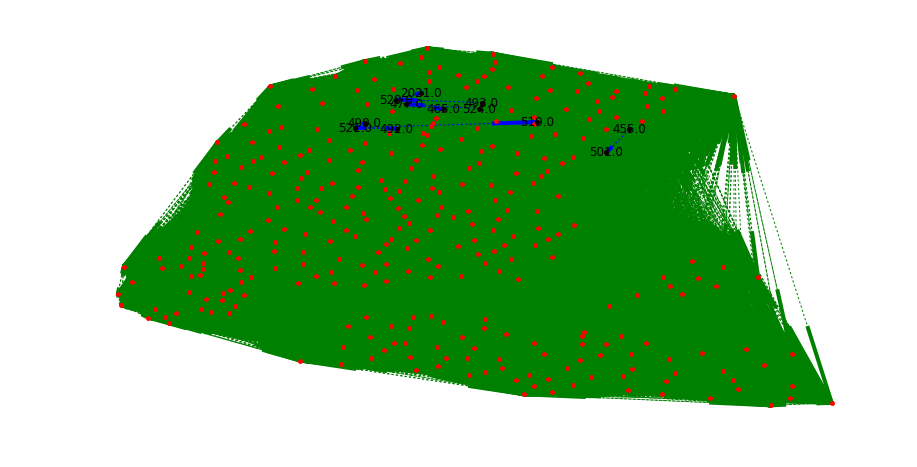

In [151]:
nx.draw(network,pos=station_positions,with_labels=False,node_size=15,style='dotted',edge_color='green',arrows=True)
nx.draw(topjumpnetwork,pos=station_positions,with_labels=True,node_size=15,style='dotted',node_color='black',edge_color='blue',arrows=True)

In [ ]:
# visualize with folium
map_bike = folium.Map(location=[40.730020, -73.969053],tiles='cartodbpositron', zoom_start=13)

for i in stations.iterrows():
    folium.CircleMarker(location=[i[1][0],i[1][1]],radius=1,fill_opacity=1).add_to(map_bike)

map_bike

# Centrality Measures

In [5]:
degree_cent = nx.centrality.degree_centrality(network)
between_cent = nx.centrality.betweenness_centrality(network, weight='inv_weight')

In [6]:
closeness_cent = nx.centrality.closeness_centrality(network,distance='inv_weight')

In [7]:
# This is “left” eigenvector centrality which corresponds to the in-edges
eigen_cent = nx.centrality.eigenvector_centrality(network,weight='inv_weight')
eigen_cent_numpy = nx.centrality.eigenvector_centrality_numpy(network,weight='inv_weight')

In [8]:
# This is “right” eigenvector centrality which corresponds to the out-edges
eigen_cent_out = nx.centrality.eigenvector_centrality(network.reverse(),weight='inv_weight')
eigen_cent_numpy_out = nx.centrality.eigenvector_centrality_numpy(network.reverse(),weight='inv_weight')

In [9]:
centralities = {'degree_centrality':degree_cent,
                'betweeness_centrality':between_cent,
                'closeness_centrality':closeness_cent,
                'eigenvector_centrality':eigen_cent,
                'eigenvector_out_centrality':eigen_cent_out}

In [10]:
for key, values in centralities.iteritems():
    stations['{}'.format(key)] = stations['start station id'].map(values)

NameError: name 'stations' is not defined

In [ ]:
stations.to_csv('centralities_citibike.csv')

In [71]:
# eight bins diverging and qualitative color palette
diverge_colors = ["#d53e4f",
                    "#f46d43",
                    "#fdae61",
                    "#fee08b",
                    "#e6f598",
                    "#abdda4",
                    "#66c2a5",
                    "#3288bd"]

qualitative_colors=['#7fc97f',
                    '#beaed4',
                    '#fdc086',
                    '#ffff99',
                    '#386cb0',
                    '#f0027f',
                    '#bf5b17',
                    '#666666',]

In [72]:
values = degree_cent.values()
bins = np.linspace(min(degree_cent.values()),max(degree_cent.values()), num=8)
binassign = np.digitize(values, bins)
binassign = binassign - 1

In [73]:
for num, centralities in enumerate([degree_cent,between_cent,closeness_cent,eigen_cent]):
    values = centralities.values()
    bins = np.linspace(min(centralities.values()),max(centralities.values()), num=8)
    binassign = np.digitize(values, bins)
    binassign = binassign - 1
    bin_dict = dict(zip(centralities.keys(), binassign))
    map_bike = folium.Map(location=[40.730020, -73.969053],
                          tiles='cartodbdark_matter',
                          zoom_start=12,
                         )

    for i in stations.iterrows():
        station_id = i[0]
        folium.CircleMarker(location=[i[1][0],i[1][1]],
                            radius=1,fill_opacity=1,
                            color=diverge_colors[bin_dict[station_id]],
                            fill_color=diverge_colors[bin_dict[station_id]]).add_to(map_bike)
    map_bike.save('centralitymap_{}.html'.format(num))

# Graph Partitioning explorations

## Spectral clustering

In [76]:
nx.directed_laplacian_matrix?

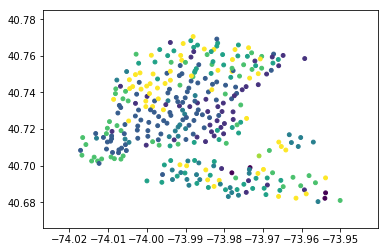

In [41]:
laplacian_matrix = nx.directed_laplacian_matrix(network)
spectral8 = sklearn.cluster.SpectralClustering()
labels = spectral8.fit_predict(laplacian_matrix)
nx.draw_networkx_nodes(network,pos=station_positions,node_color=labels,
                       with_labels=False,node_size=15)

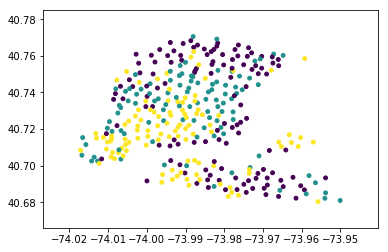

In [22]:
# three clusters
spectral = sklearn.cluster.SpectralClustering(n_clusters=3)
labels = spectral.fit_predict(laplacian_matrix)
nx.draw_networkx_nodes(network,pos=station_positions,node_color=labels,with_labels=False,node_size=15)

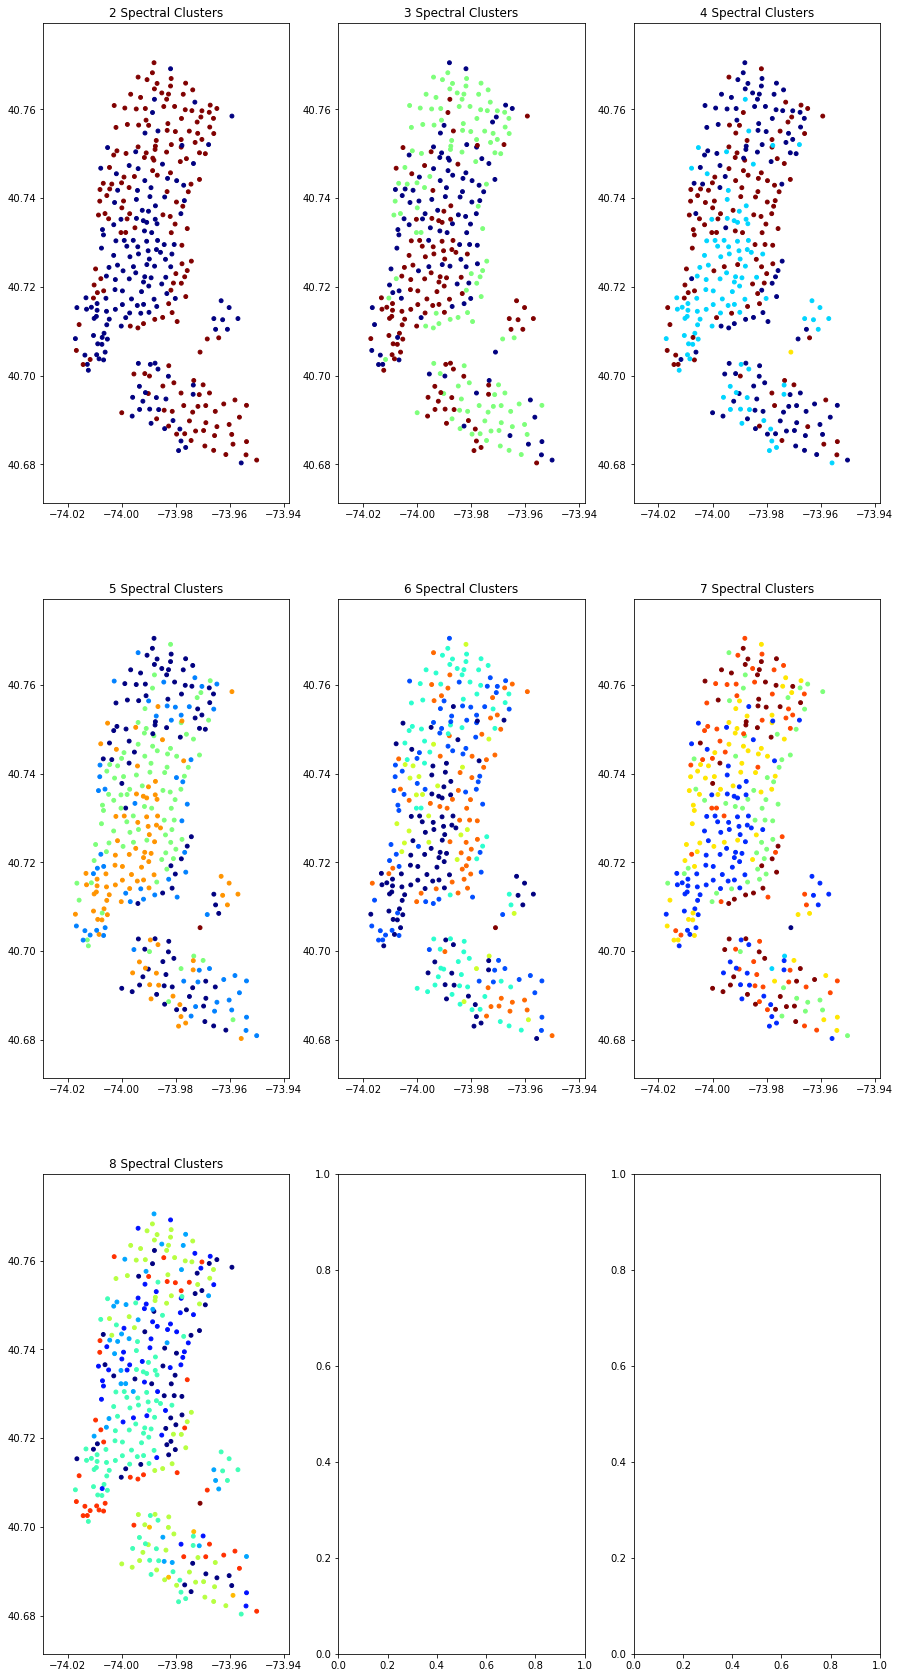

In [23]:
# clusters of sizes 2 to 8
fig, axes = plt.subplots(ncols=3,nrows=3, figsize = (15,30))
for ax, i in zip(axes.flatten(), range(2,9)):
    spectral = sklearn.cluster.SpectralClustering(n_clusters=i)
    labels = spectral.fit_predict(laplacian_matrix)
    nx.draw_networkx_nodes(network,pos=station_positions,node_color=labels,cmap='jet',with_labels=False,
                           node_size=15, ax=ax)
    ax.set_title('{} Spectral Clusters'.format(i))

In [24]:
three_spectral_clusters = dict(zip(network.nodes(),labels))

In [74]:
map_bike = folium.Map(location=[40.730020, -73.969053],
                      tiles='cartodbpositron',
                      zoom_start=12,
                     )
for value in stations.iterrows():
    bikeid = value[0]
    folium.RegularPolygonMarker(location=[value[1][0],value[1][1]],
                        fill_opacity=0.1, 
                        radius=2,
                        color=qualitative_colors[three_spectral_clusters[bikeid]],
                        fill_color=qualitative_colors[three_spectral_clusters[bikeid]],
                        popup='{}, cluster {}'.format(value[1][2],three_spectral_clusters[bikeid])).add_to(map_bike)
map_bike

# Hierarchical Clustering

In [20]:
def create_hc(G):
    """Creates hierarchical cluster of graph G from distance matrix"""
    path_length=nx.all_pairs_shortest_path_length(G)
    distances=np.zeros((len(G),len(G)))
    for u,p in path_length.items():
        for v,d in p.items():
            distances[u][v]=d
    # Create hierarchical cluster
    Y=distance.squareform(distances)
    Z=hierarchy.complete(Y)  # Creates HC using farthest point linkage
    S = hierarchy.single(Y)  # Creates HC using single linkage
    # This partition selection is arbitrary, for illustrive purposes
    membership=list(hierarchy.fcluster(Z,t=1.15))
    # Create collection of lists for blockmodel
    partition=defaultdict(list)
    for n,p in zip(list(range(len(G))),membership):
        partition[p].append(n)
#    return list(partition.values())

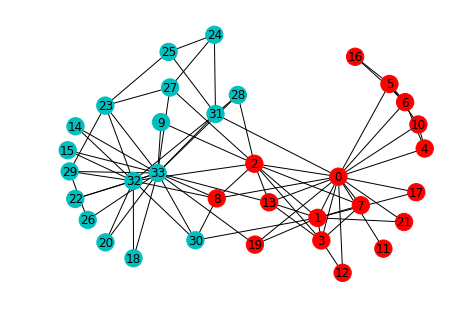

In [42]:
# Karate club example

G=nx.karate_club_graph()
pos = nx.spring_layout(G)

colors = {}
for key, value in G.node.iteritems():
    if value['club'] == 'Mr. Hi':
        colors[key] = 'r'
    else:
        colors[key] = 'c'
nx.draw(G,pos=pos,node_color=colors.values(),with_labels=True)

path_length=nx.all_pairs_shortest_path_length(G)
distances=np.zeros((len(G),len(G)))
for u,p in path_length.items():
    for v,d in p.items():
        distances[u][v]=d
# Create hierarchical cluster
Y = distance.pdist(distances)
Z = hierarchy.complete(Y)  # Creates HC using farthest point linkage
S = hierarchy.single(Y)  # Creates HC using single linkage

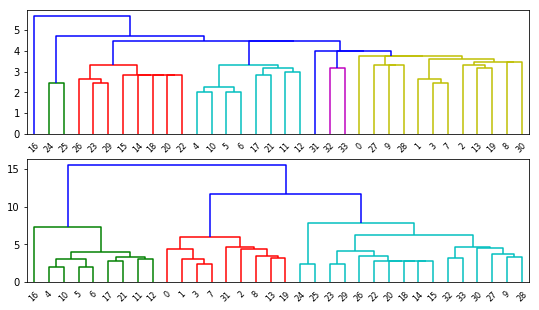

In [43]:
fig, axes = plt.subplots(2, 1, figsize=(9, 5))
dn = hierarchy.dendrogram(S, ax=axes[0],)
dn1 = hierarchy.dendrogram(Z, ax=axes[1])

In [44]:
cutree = hierarchy.cut_tree(S)

In [45]:
hier_labels = {}
colors = ['r','b','g','y']
for i, val in enumerate(cutree.T[30]):
    hier_labels[i] = colors[val]
nx.set_node_attributes(G,'cut_hierachical',hier_labels)

In [46]:
laplacian_karate = nx.laplacian_matrix(G)
w, v = np.linalg.eig(laplacian_karate.toarray())

w_sorted = np.sort(w)
eig_index = list(w).index(w_sorted[1])
w_sorted[1]
second_eigen = v[:,eig_index]

spectral_labels = {}
for i,val in enumerate(second_eigen):
    if val < 0:
        spectral_labels[i] = 'y'
    else:
        spectral_labels[i] = 'g'
nx.set_node_attributes(G,'spectral_bi',spectral_labels)

{0: <matplotlib.text.Text at 0x127c24650>,
 1: <matplotlib.text.Text at 0x128be45d0>,
 2: <matplotlib.text.Text at 0x128be4310>,
 3: <matplotlib.text.Text at 0x1294c5890>,
 4: <matplotlib.text.Text at 0x1294c5e10>,
 5: <matplotlib.text.Text at 0x1294c5790>,
 6: <matplotlib.text.Text at 0x128ba6410>,
 7: <matplotlib.text.Text at 0x128ba6250>,
 8: <matplotlib.text.Text at 0x128ba63d0>,
 9: <matplotlib.text.Text at 0x1270102d0>,
 10: <matplotlib.text.Text at 0x12703ca90>,
 11: <matplotlib.text.Text at 0x12703ce10>,
 12: <matplotlib.text.Text at 0x126d1db10>,
 13: <matplotlib.text.Text at 0x126d1d350>,
 14: <matplotlib.text.Text at 0x126c56850>,
 15: <matplotlib.text.Text at 0x126c567d0>,
 16: <matplotlib.text.Text at 0x128c4aa50>,
 17: <matplotlib.text.Text at 0x128c4abd0>,
 18: <matplotlib.text.Text at 0x128c4a410>,
 19: <matplotlib.text.Text at 0x126d42690>,
 20: <matplotlib.text.Text at 0x126d42790>,
 21: <matplotlib.text.Text at 0x1131e0dd0>,
 22: <matplotlib.text.Text at 0x126d28bd0>

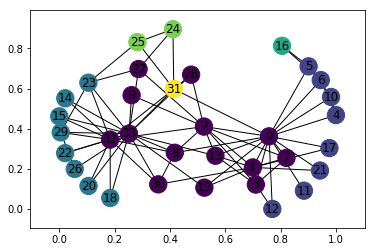

In [47]:
nx.draw_networkx_nodes(G,pos,pos,node_color=cutree.T[28])
nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G, pos)

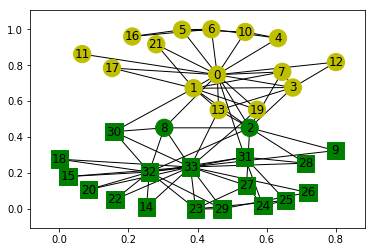

In [18]:
pos = nx.spring_layout(G, pos=pos)
nx.draw_networkx_nodes(G,pos,with_labels=True,nodelist=[i for i, val in G.node.iteritems() if val['spectral_bi']==0],node_shape='d',node_color='b')
nx.draw_networkx_nodes(G,pos,with_labels=True,nodelist=[i for i, val in G.node.iteritems() if val['spectral_bi']==1],node_shape='s',node_color='g')
nx.draw_networkx_nodes(G,pos,with_labels=True,nodelist=[i for i, val in G.node.iteritems() if val['club']=='Mr. Hi'],node_shape='o',
                       node_color=[val['spectral_bi'] for i, val in G.node.iteritems() if val['club']=='Mr. Hi'])
nx.draw_networkx_nodes(G,pos,with_labels=True,nodelist=[i for i, val in G.node.iteritems() if val['club']=='Officer'],
                       node_shape='s',
                       node_color=[val['spectral_bi'] for i, val in G.node.iteritems() if val['club']=='Officer'])
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G,pos)

In [94]:
# now with citibike network
network.nodes

path_length=nx.all_pairs_shortest_path_length(network)
distances = pd.DataFrame.from_dict(path_length, orient = 'index')
# Create hierarchical cluster
Y = distance.pdist(distances)
Z = hierarchy.complete(Y)  # Creates HC using farthest point linkage
S = hierarchy.single(Y)  # Creates HC using single linkage

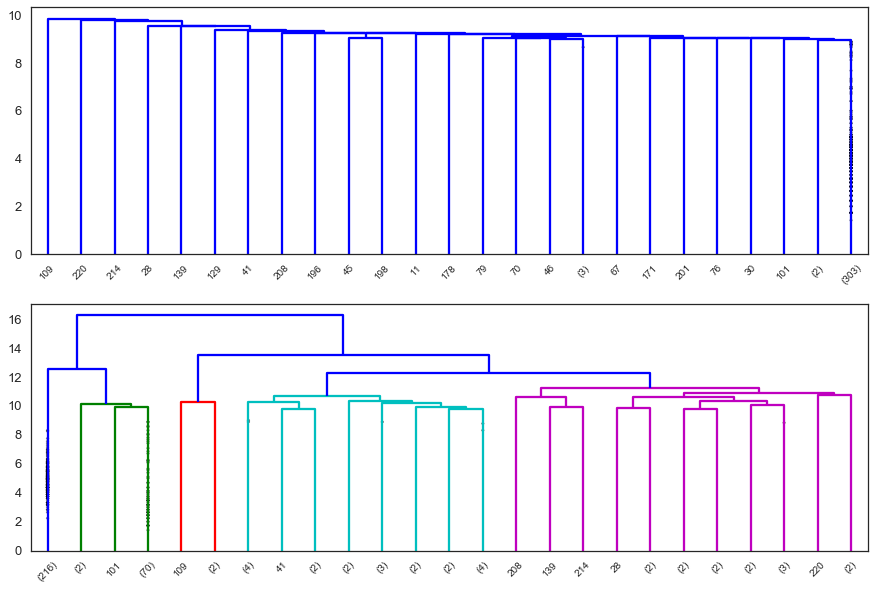

In [238]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
dn = hierarchy.dendrogram(S, truncate_mode = 'lastp', p = 25, show_contracted = True, 
                          ax=axes[0])
axes[0].title('Truncated Dendrogram of CitiBike Interconnecte')
dn1 = hierarchy.dendrogram(Z, truncate_mode = 'lastp', p = 25, show_contracted = True, 
                           ax=axes[1])


In [ ]:
network2 = nx.from_pandas_dataframe(od,
                                   source= 'start station id',
                                   target='end station id',
                                   edge_attr='inv_weight',
                                   create_using=nx.DiGraph())


# More explorations of networkx

In [49]:
degrees = network.degree(weight='weight')
in_degrees = network.in_degree(weight='weight')
out_degrees = network.out_degree(weight='weight')

In [50]:
network.subgraph([72,79]).degree()

{72: 4, 79: 4}

In [51]:
network.size()

95630

In [52]:
from networkx.algorithms import approximation

In [53]:
strong_connected = nx.is_strongly_connected(network)
weak_connected = nx.is_weakly_connected(network)
weak_components = nx.weakly_connected_components(network)

In [54]:
print strong_connected
print weak_connected

True
True


In [55]:
one_node_nonneighbors = [i for i in nx.non_neighbors(network,72)]

In [56]:
G = nx.barbell_graph(m1=5, m2=1)

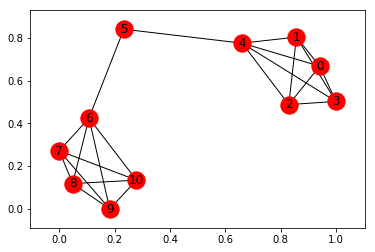

In [57]:
nx.draw_networkx(G)

In [58]:
centralityG = nx.centrality.betweenness_centrality(G)

In [59]:
centralityG

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.5333333333333333,
 5: 0.5555555555555556,
 6: 0.5333333333333333,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0}

In [60]:
list(nx.find_cliques(G))

[[4, 0, 1, 2, 3], [4, 5], [6, 8, 9, 10, 7], [6, 5]]

In [61]:
nx.triangles(G)

{0: 6, 1: 6, 2: 6, 3: 6, 4: 6, 5: 0, 6: 6, 7: 6, 8: 6, 9: 6, 10: 6}

In [62]:
flow_value, flow_dict = nx.maximum_flow(network, 72, 79, capacity='inv_weight')

In [63]:
flow_value

30.511215329257062

In [64]:
import networkx as nx
T = nx.DiGraph()
T.add_edge('x','a', capacity=3.0)
T.add_edge('x','b', capacity=1.0)
T.add_edge('a','c', capacity=3.0)
T.add_edge('b','c', capacity=5.0)
T.add_edge('b','d', capacity=4.0)
T.add_edge('d','e', capacity=2.0)
T.add_edge('c','y', capacity=2.0)
T.add_edge('e','y', capacity=3.0)

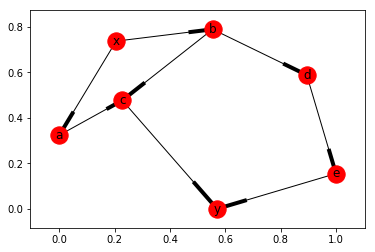

In [65]:
nx.draw_networkx(T,with_labels=True)

In [66]:
flow_value, flow_dict = nx.maximum_flow(T, 'x', 'c', capacity='capacity')

In [67]:
flow_value

4.0

In [68]:
flow_dict

{'a': {'c': 3.0},
 'b': {'c': 1.0, 'd': 0},
 'c': {'y': 0},
 'd': {'e': 0},
 'e': {'y': 0},
 'x': {'a': 3.0, 'b': 1.0},
 'y': {}}

In [69]:
cent = nx.centrality.betweenness_centrality(network, weight='inv_weight')

In [70]:
centralities = pd.DataFrame({'station_id': list(cent.keys()), 'cents': list(cent.values())}).set_index('station_id')

In [144]:
station = []
position = []
for k, v in station_positions.iteritems():
    station.append(float(k))
    position.append(Point(v))
dist_locat = pd.DataFrame({'station': station, 'geometry': position})
dist_locat = dist_locat.sort_values('station')
dist_locat = gp.GeoDataFrame(dist_locat)

In [192]:
from sklearn.cluster import KMeans
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

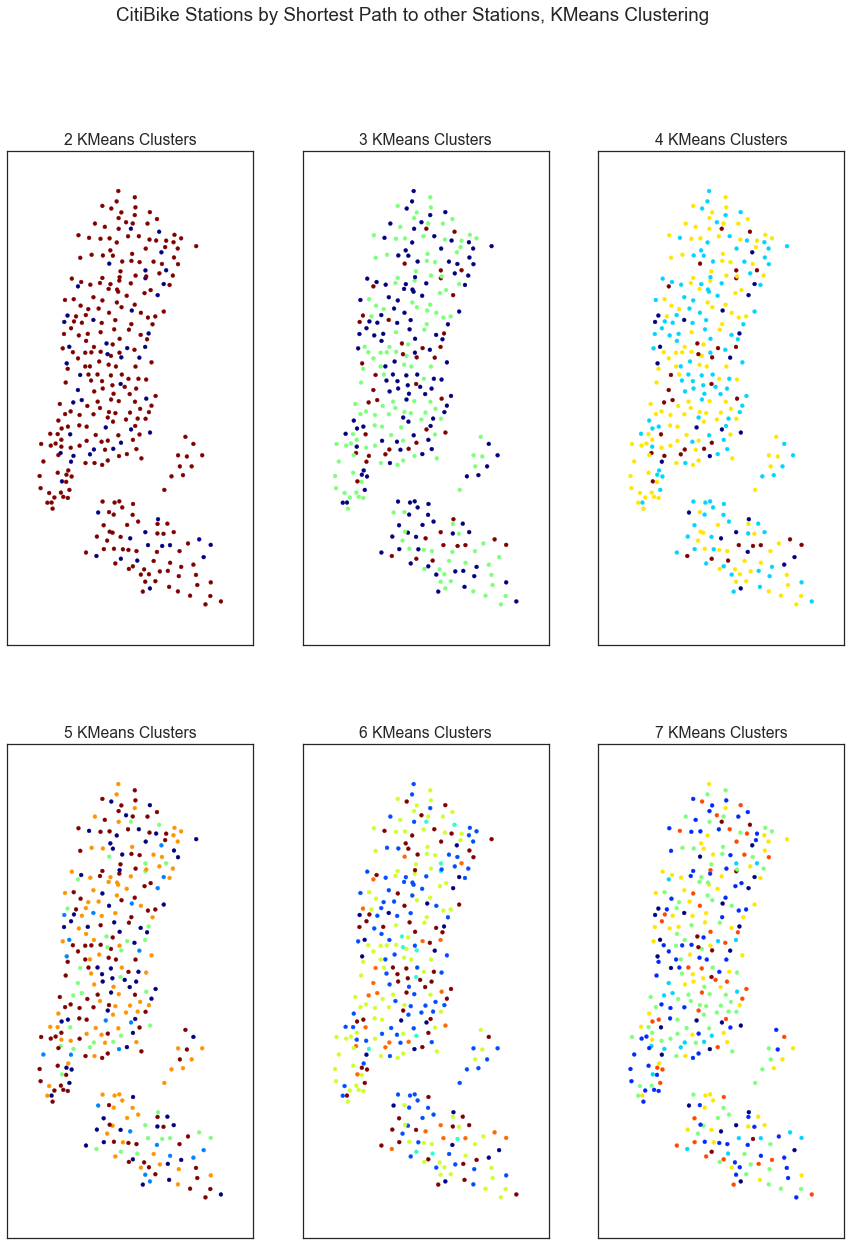

In [231]:
fig, axes = plt.subplots(ncols=3,nrows=2, figsize = (15,20))
for ax, i in zip(axes.flatten(), range(2,8)):
    km = KMeans(n_clusters=i)
    labels = km.fit_predict(distances)
    nx.draw_networkx_nodes(network,pos=station_positions,node_color=labels,
                       with_labels=False,node_size=15, ax = ax, cmap = 'jet')
    ax.set_title('{} KMeans Clusters'.format(i))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.suptitle('CitiBike Stations by Shortest Path to other Stations, KMeans Clustering')
plt.savefig('kmeans.png')

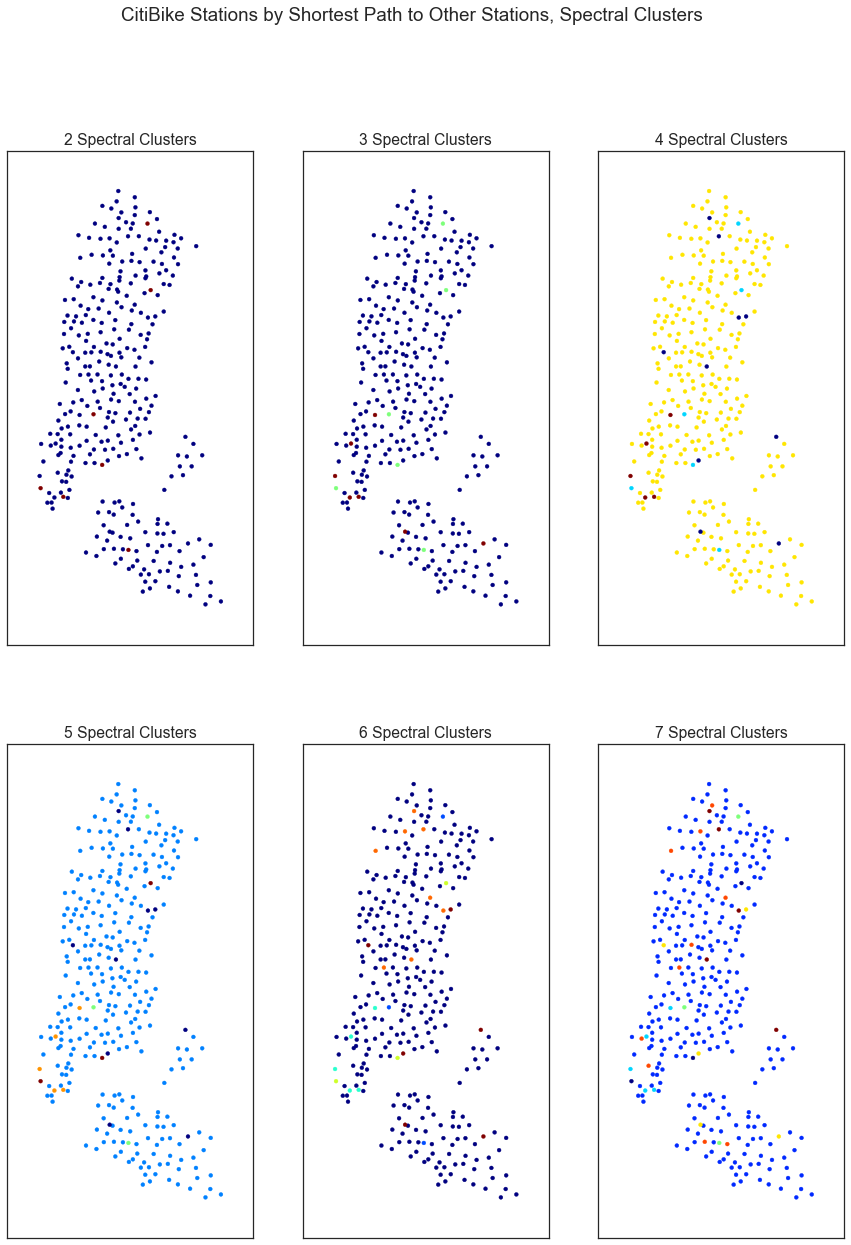

In [229]:
fig, axes = plt.subplots(ncols=3,nrows=2, figsize = (15,20))
for ax, i in zip(axes.flatten(), range(2,8)):
    spectral = sklearn.cluster.SpectralClustering(n_clusters=i)
    labels = spectral.fit_predict(distances)
    nx.draw_networkx_nodes(network,pos=station_positions,node_color=labels,
                       with_labels=False,node_size=15, ax = ax, cmap = 'jet')
    ax.set_title('{} KMeans Clusters'.format(i))
    ax.set_title('{} Spectral Clusters'.format(i))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.suptitle('CitiBike Stations by Shortest Path to Other Stations, Spectral Clusters')
plt.savefig('spectral.png')
    

In [176]:
Y = distance.pdist(distances)
Z = hierarchy.complete(Y)  # Creates HC using farthest point linkage
S = hierarchy.single(Y)  # Creates HC using single linkage
hierarchy.fclusterdata

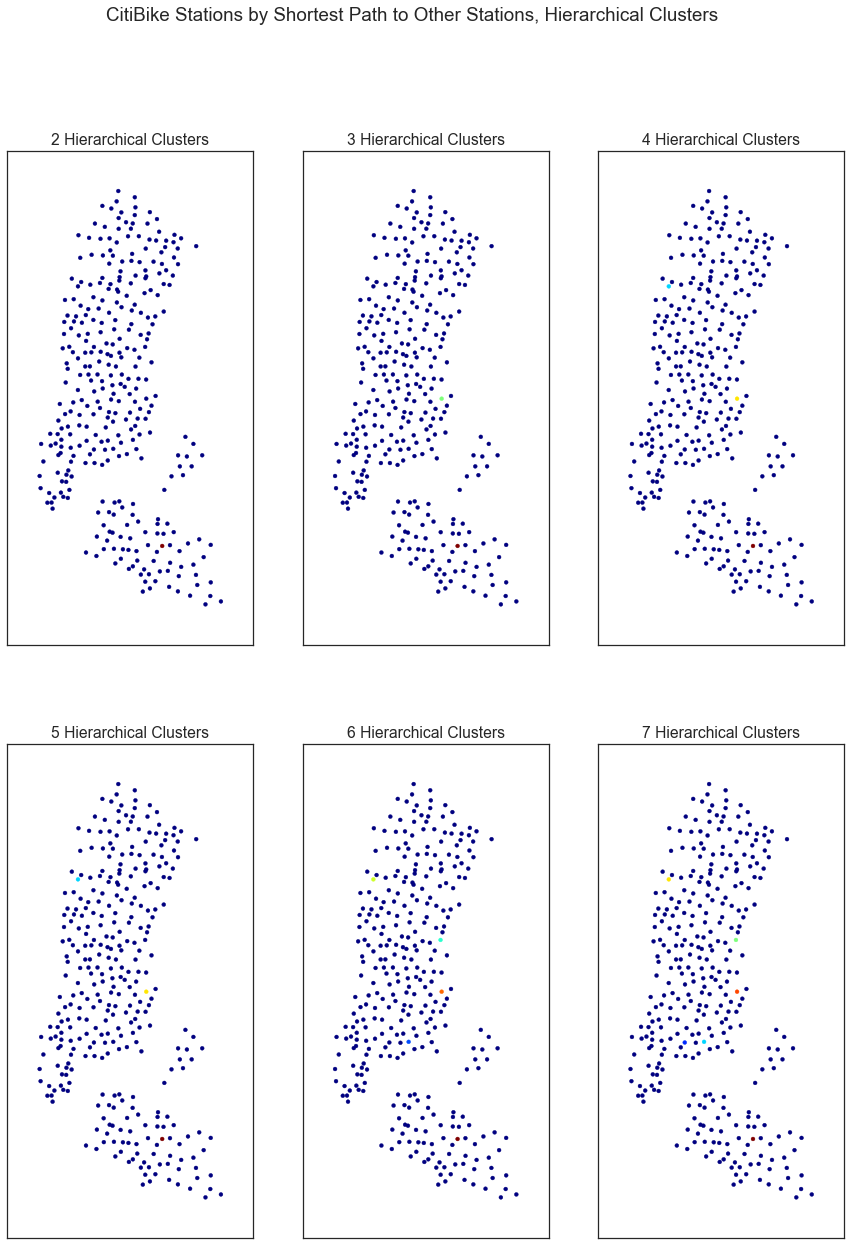

In [230]:
fig, axes = plt.subplots(ncols=3,nrows=2, figsize = (15,20))
for ax, i in zip(axes.flatten(), range(2,8)):
    labels = hierarchy.fclusterdata(distances, i, criterion = 'maxclust')
    nx.draw_networkx_nodes(network,pos=station_positions,node_color=labels,
                       with_labels=False,node_size=15, ax = ax, cmap = 'jet')
    ax.set_title('{} Hierarchical Clusters'.format(i))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.suptitle('CitiBike Stations by Shortest Path to Other Stations, Hierarchical Clusters')
plt.savefig('hier.png')

In [223]:
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1,